# **ABSTRACT**

The motivation for this project comes from a personal interest in music, particularly in what makes a song or artist popular. Nowadays, from a personal perspective, the goal of music has shifted from creating quality work to creating a product that maximizes sales. However, hit songs seem to come in different shapes and forms, giving rise to the question: What exactly is it that makes a song or artist popular? Can a song's popularity be predicted before release? Can a song be adjusted before release to increase this predicted popularity? Providing answers to these questions are the primary motivation for the project at hand.

As for the target audience, this project may be of interest to anyone who would like to predict a song's popularity prior to it's release. In this sense, it could be of special interest to any aspiring artist interested in evaluating their music and modifying it to maximize sales.

The used dataset has information from 114000 songs. The attributes for these songs are primarily numerical and describe different aspects of the song, such as danceability, duration, loudness, energy, genre, etc. All these songs also have popularity ratings between 0 and 100, which are determined by the number of streamings, the position in top rankings, and the like. The purpose of the current notebook is to build a regression model capable to predict a song's popularity rating based on other song variables. The dataset was taken from Spotify databases, and was obtained from the following website 

https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

### **Import libraries and load data**

In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
import IPython
import sklearn as skl
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, median_absolute_error, max_error, get_scorer_names
import tqdm
from tqdm import tqdm
import sqlite3
from pathlib import Path


In [2]:
path = 'music.csv'
df = pd.read_csv(path, sep = ',', index_col=0)
display(df.head(5))
df.shape

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


(114000, 20)

### **Data preprocessing**

#### **Handling of duplicates and missing values**

In [3]:
# Search for unique and missing values
display(df.nunique().to_frame().T.set_index(pd.Index(['unique_value_count'])))
df.isnull().sum().to_frame().T.set_index(pd.Index(['missing_value_count']))

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
unique_value_count,89741,31437,46589,73608,101,50697,2,1174,2083,12,19480,2,1489,5061,5346,1722,1790,45653,5,114


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
missing_value_count,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df[df.isnull().any(axis = 1)]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


There is only one row with missing values in the entire dataset, and those missing values correspond to variables 'artists', 'album_name' and 'track_name'. As these variables probably won't be used for the analysis, no action is taken towards the row at hand.

Nevertheless, it seems odd that the number of unique values for the variable 'track_id' does not match the number of rows of the dataset. This is studied below.

In [5]:
# Search for duplicate values
display(df[df.duplicated(keep = 'first')].head())
df[df.duplicated(keep = 'first')].shape

# Dropping duplicates
df.drop_duplicates(inplace= True)
print (df.shape)
df[df.duplicated()]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
1925,0CDucx9lKxuCZplLXUz0iX,Buena Onda Reggae Club,Disco 2,Song for Rollins,16,219346,False,0.841,0.577,0,-7.544,1,0.0438,0.238000,0.860000,0.0571,0.843,90.522,4,afrobeat
2155,2aibwv5hGXSgw7Yru8IYTO,Red Hot Chili Peppers,Stadium Arcadium,Snow (Hey Oh),80,334666,False,0.427,0.900,11,-3.674,1,0.0499,0.116000,0.000017,0.1190,0.599,104.655,4,alt-rock
3738,7mULVp0DJrI2Nd6GesLvxn,Joy Division,Timeless Rock Hits,Love Will Tear Us Apart,0,204621,False,0.524,0.902,2,-8.662,1,0.0368,0.000989,0.695000,0.1370,0.907,146.833,4,alternative
4648,6d3RIvHfVkoOtW1WHXmbX3,Little Symphony,Serenity,Margot,27,45714,False,0.269,0.142,0,-23.695,1,0.0509,0.866000,0.904000,0.1140,0.321,67.872,3,ambient
5769,481beimUiUnMUzSbOAFcUT,SUPER BEAVER,突破口 / 自慢になりたい,突破口,54,255080,False,0.472,0.994,8,-1.786,1,0.1140,0.025900,0.000000,0.0535,0.262,103.512,4,anime


(113550, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre


There were 450 duplicate valures in the dataset. which are now dropped, modifying the original dataset.

The only column value that should not be repeated throughtout the current dataset is track_id, as all the other ones are variables that could be repeated between tracks. Therefore, duplicates are looked for considering only the track_id column.

In [6]:
# Get duplicated rows ordered by track ID, so as to identify differences between rows with the same track ID
df_duplicates = df[df.duplicated(subset=['track_id'],keep=False)].sort_values(axis=0, by='track_id')

# From duplicate dataset preview, it appears the only difference between track_id duplicates is in the column track_genre.
duplicates_set = set()

# Generate a set with track_ids that have duplicates
for row in df_duplicates.index:
    duplicates_set.add(df_duplicates.loc[row].track_id)

# Check if duplicate values differ only in track_genre column. If so, problem_tracks should remain an empty list.
problem_tracks = []

for track_id in tqdm(duplicates_set, desc= 'progress'):
    l = df_duplicates[df_duplicates['track_id'] == track_id].nunique().to_list() # generate a list with the number of unique values for every column of duplicate tracks
    if sum(l[0:-1]) != 19:
        problem_tracks.append(track_id) # There are 20 values in the list, so if the only difference is in track_genre (last column), the sum of the first values should always be 19

progress: 100%|██████████| 16299/16299 [03:03<00:00, 88.59it/s] 


In [7]:
print (f'There are {len(duplicates_set)} tracks that appear more than once')
print (f'From these tracks, {len(duplicates_set) - len(problem_tracks)} are tracks that appear more than once with different genres. This is, all values are the same except for track_genre')
print (f'The other {len(problem_tracks)} are tracks which differ in another column, though they may also differ in track_genre. Below, it is checked if this column is popularity')

tracks_diff_pop = set()

for track_id in problem_tracks:
    df_problem = df_duplicates[df_duplicates['track_id'] == track_id].nunique()
    
    if df_problem['popularity'] != 1 and df_problem['track_genre'] != 1 and sum(df_problem['track_id' : 'track_name']) == 4 and sum(df_problem['duration_ms' : 'time_signature']) == 14:
        tracks_diff_pop.add(track_id)   

print (f' \nThe length of problem_tracks ({len(problem_tracks)} tracks) is the same as the length of tracks_diff_pop ({len(tracks_diff_pop)} tracks). This means that the 720 duplicate tracks which differ in columns other than track_genre, actually ONLY differ both in popularity and track genre, but differ in no other column.')

There are 16299 tracks that appear more than once
From these tracks, 15579 are tracks that appear more than once with different genres. This is, all values are the same except for track_genre
The other 720 are tracks which differ in another column, though they may also differ in track_genre. Below, it is checked if this column is popularity
 
The length of problem_tracks (720 tracks) is the same as the length of tracks_diff_pop (720 tracks). This means that the 720 duplicate tracks which differ in columns other than track_genre, actually ONLY differ both in popularity and track genre, but differ in no other column.


In [8]:
# Find the popularity range for the tracks with multiple values of popularity
problem_tracks_dict = {}
for track_id in problem_tracks:
    min_pop = df_duplicates[df_duplicates['track_id'] == track_id].min()['popularity']
    max_pop = df_duplicates[df_duplicates['track_id'] == track_id].max()['popularity']
    problem_tracks_dict[track_id] = max_pop - min_pop

#print (problem_tracks_dict.values())

counter = 0
counter_equal_2 = 0
counter_equal_1 = 0
for i in problem_tracks_dict.values():
    if i > 2:
        counter += 1
    elif i == 2:
        counter_equal_2 += 1
    elif i == 1:
        counter_equal_1 += 1

print (f'There are {counter} tracks with a popularity range greater than two points')
print (f'There are {counter_equal_2} tracks with a popularity range of two points')
print (f'There are {counter_equal_1} tracks with a popularity range of one point')

There are 30 tracks with a popularity range greater than two points
There are 17 tracks with a popularity range of two points
There are 673 tracks with a popularity range of one point


Most tracks which have multiple levels of popularity actually have a popularity range of only one point. For these tracks, considering either minimum or maximum popularity rating will make no difference for the analysis.

Furthermore, there are only 30 tracks with a popularity range greater than two points, 20 of which are tracks of which there is only one appearance with a popularity rating different from zero, while all other appearances have a popularity rating of zero (this can be seen by displaying the tracks). For these tracks, appearances with popularity ratings of zero are disregarded, keeping only the appearance with a popularity rating different from zero. This will be done by keeping the appearance with maximum popularity rating.

Applying the same criteria for the remaining 10 tracks (tracks which have a popularity range greater than two points but with no appearance with 0 popularity), as well as for the 17 tracks with a popularity range of two points, will make no differece for the analysis, as the popularity ranges are still small.

It is also worth noting that, according to Spotify, the popularity rating for any given song primarily depends on the number of streams. Hence, it is considered that the highest popularity rating for a duplicated song should be the most representative one, as it the one which got listened to the most.

**CONCLUSION:** 

**For the 720 tracks with more than one appearance, differing both in track genre and popularity, the appearance with maximum popularity shall be kept, dropping all other appearances.**
**For the 15579 tracks which differ only in track genre, the appearance whose genre appears more times for that artist is kept**

In [9]:
# Keep tracks with maximum popularity from mentioned 720 tracks (tracks' id stored in problem_tracks)
print (df.shape)
for track_id in problem_tracks:
    max_pop = df_duplicates[df_duplicates['track_id'] == track_id].max()['popularity']
    row = df[(df['popularity'] != max_pop) & (df['track_id'] == track_id)].index
    df = df.drop(row)

df.shape

(113550, 20)


(112567, 20)

In [10]:
# Update duplicates dataframe and set (with track_ids that have duplicates)
df_duplicates = df[df.duplicated(subset=['track_id'],keep=False)].sort_values(axis=0, by='track_id')

duplicates_set = set()

for row in tqdm(df_duplicates.index):
    duplicates_set.add(df_duplicates.loc[row].track_id)

100%|██████████| 38593/38593 [00:05<00:00, 7331.25it/s]


In [11]:
# Keep tracks whose genre equals the genre mode for the artist
for track_id in tqdm(duplicates_set):
   df_duplicated_track = df_duplicates[df_duplicates['track_id'] == track_id] # dataframe with duplicate values of each track_id
   artist = df_duplicated_track.artists.to_list()[0] # artist of duplicated track

   artist_genre_count = list(df[df['artists'] == artist].track_genre.value_counts().to_dict().keys()) # list of genres ordered by number of appearances
   index_dict = {}
   for track_genre in df_duplicated_track.track_genre:
      index_dict[artist_genre_count.index(track_genre)] = track_genre

   min_index = min(index_dict.keys())
   genre_to_keep = index_dict[min_index]

   row = df[(df['track_genre'] != genre_to_keep) & (df['track_id'] == track_id)].index # The duplicate value kept is that whose genre is most common for the artist of the track 
   df = df.drop(row)

print (df.shape)


100%|██████████| 15767/15767 [16:38<00:00, 15.78it/s]

(89741, 20)


In [12]:
df.reset_index(inplace = True, drop = True)

# Check modifications in current dataframe
print (df.shape)

# Check unique and missing values (number of track_id unique values should match number of rows of the modified dataset)
display(df.nunique().to_frame().T.set_index(pd.Index(['unique_value_count'])))
display (df.isnull().sum().to_frame().T.set_index(pd.Index(['missing_value_count'])))

# Check duplicate values
display (df[df.duplicated(keep='first')])

# Check duplicate values for track_id column
display (df[df.duplicated(subset = ['track_id'], keep='first')])


(89741, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
unique_value_count,89741,31437,46589,73608,101,50697,2,1174,2083,12,19480,2,1489,5061,5346,1722,1790,45653,5,113


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
missing_value_count,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre


#### **Track genre analysis**

There are 113 different genres in the modified dataset. As this column will be used for the analysis, the variable should be encoded. For this encoding, track genre clusters will be created, joining together track genres with similar distributions of popularity. Therefore, a new variable will be created containing the track genre cluster of the track's genre. This variable will then be encoded using dummy variables. This is done below.

In [13]:
# Pass modified dataframe to sql
conn = sqlite3.connect ('./databases/music.db')
df.to_sql(name= 'music_filtered', con=conn, if_exists= 'replace')

89741

In [14]:
# Dataframe grouped by genre
query = '''SELECT track_genre, count (track_id) count, min (popularity) min, max (popularity) max, round(avg(popularity),2) mean 
            FROM music_filtered 
            GROUP BY track_genre'''

df_grouped_filtered = pd.read_sql_query(query, conn)

df_grouped_filtered['median'] = list(df.groupby(df['track_genre'])['popularity'].median())

df_grouped_filtered

,track_genre,count,min,max,mean,median
0,acoustic,968,0,82,42.64,47.0
1,afrobeat,999,0,75,24.41,21.0
2,alt-rock,490,0,93,39.02,46.0
3,alternative,255,0,87,19.38,0.0
4,ambient,898,0,84,45.35,50.0
...,...,...,...,...,...,...
108,techno,451,0,79,39.26,41.0
109,trance,851,0,86,36.65,38.0
110,trip-hop,968,0,71,34.24,38.0
111,turkish,887,0,77,40.49,40.0


In [15]:
cols_to_scale = df_grouped_filtered.columns.to_list() 
cols_to_scale.pop(cols_to_scale.index('track_genre'))

df_grouped_filtered[cols_to_scale]

,count,min,max,mean,median
0,968,0,82,42.64,47.0
1,999,0,75,24.41,21.0
2,490,0,93,39.02,46.0
3,255,0,87,19.38,0.0
4,898,0,84,45.35,50.0
...,...,...,...,...,...
108,451,0,79,39.26,41.0
109,851,0,86,36.65,38.0
110,968,0,71,34.24,38.0
111,887,0,77,40.49,40.0


In [16]:
# K-Means to create genre clusters
# As K-Means is a distance-based algorithm, the dataset is scaled before applying the algorithm.
# After some iterations, and considering that the optimal number of clusters tends to be about sqrt(n), a total number of 10 clusters is chosen.

cols_to_scale = df_grouped_filtered.columns.to_list() 
cols_to_scale.pop(cols_to_scale.index('track_genre'))
df_grouped_filtered_scaled = pd.DataFrame(data = StandardScaler().fit_transform(df_grouped_filtered[cols_to_scale]), columns = cols_to_scale)

kmeans = KMeans(init= 'random', n_clusters=10, n_init=10, max_iter=300)
columns = list(df_grouped_filtered_scaled.columns)

features = df_grouped_filtered_scaled[columns]

kmeans.fit (features)

KMeans(init='random', n_clusters=10, n_init=10)

In [17]:
df_grouped_filtered['var_cluster'] = kmeans.labels_
df_grouped_filtered

,track_genre,count,min,max,mean,median,var_cluster
0,acoustic,968,0,82,42.64,47.0,5
1,afrobeat,999,0,75,24.41,21.0,0
2,alt-rock,490,0,93,39.02,46.0,8
3,alternative,255,0,87,19.38,0.0,7
4,ambient,898,0,84,45.35,50.0,5
...,...,...,...,...,...,...,...
108,techno,451,0,79,39.26,41.0,9
109,trance,851,0,86,36.65,38.0,6
110,trip-hop,968,0,71,34.24,38.0,4
111,turkish,887,0,77,40.49,40.0,4


In [18]:
dict_clusters = dict.fromkeys(df_grouped_filtered.track_genre)

for genre in df_grouped_filtered.iterrows():
    dict_clusters[genre[1]['track_genre']] = genre[1]['var_cluster']

df['track_genre_cluster'] = [dict_clusters[genre] for genre in df['track_genre']] # Add column do dataframe with track_genre cluster variable

In [19]:
# Generate dummy variables for every track_genre cluster
for i in set(df['track_genre_cluster']):
    df['track_genre_cluster_' + str(i)] = (df['track_genre_cluster'] == i).replace({True: 1, False: 0})

df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,track_genre_cluster_0,track_genre_cluster_1,track_genre_cluster_2,track_genre_cluster_3,track_genre_cluster_4,track_genre_cluster_5,track_genre_cluster_6,track_genre_cluster_7,track_genre_cluster_8,track_genre_cluster_9
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0,0,0,0,1,0,0,0,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0,0,0,0,0,1,0,0,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0,0,0,0,0,1,0,0,0,0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0,0,0,0,0,1,0,0,0,0
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0,0,0,0,0,1,0,0,0,0


#### **First visualizations**

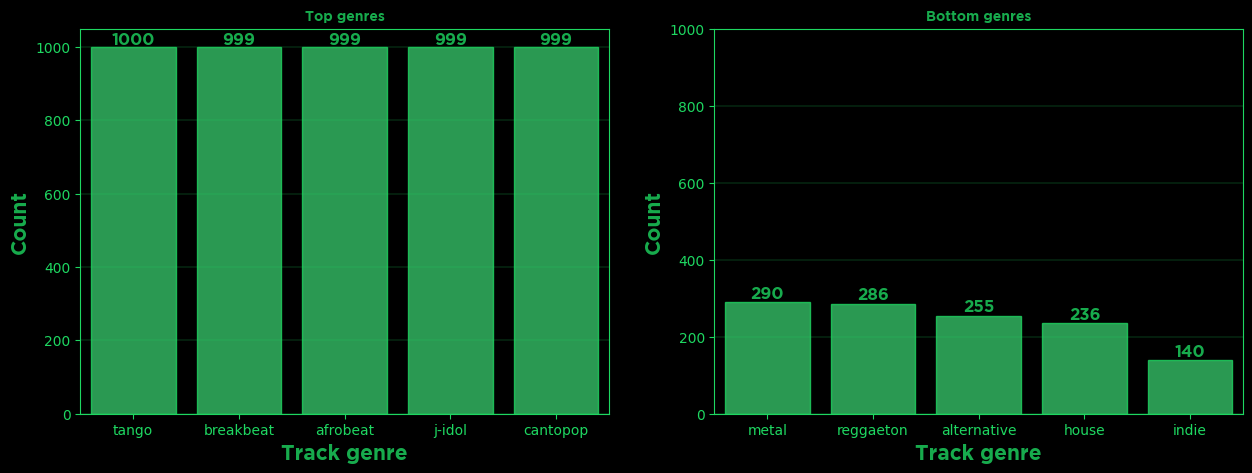

In [20]:
df_grouped_filtered_sorted = df_grouped_filtered.sort_values(by='count', ascending=False)

# Plotting
fpath = Path(mpl.get_data_path(), r"C:\Users\diego\OneDrive\Desktop\CoderHouse\GothamBold.ttf")
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
fig.set_facecolor('#000000')

# Top Genres
ax = ax1.flat[0]
sns.barplot(x = df_grouped_filtered_sorted.head()['track_genre'], y = df_grouped_filtered_sorted.head()['count'], color='#1ED761', alpha = 0.8, edgecolor = '#1ED761', ax=ax)
ax.set_facecolor('#000000')

for i in range(5):
    params = dict (color = '#1ED761', size = 12, weight = 'bold', mouseover = True, fontstretch = 'condensed', ma = 'center', font=fpath, alpha = 0.8)
    plt.text(x=-6+i, y=list(df_grouped_filtered_sorted.head()['count'])[i]-40, s=list(df_grouped_filtered_sorted.head()['count'])[i], ha='center', fontdict = params)

ax.set_xlabel ('Track genre', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.set_ylabel ('Count', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.set_title ('Top genres', fontsize = 20, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)

ax.tick_params (axis='x', colors = '#1ED761', rotation = 0)
ax.tick_params (axis='y', colors = '#1ED761')

for spine in ax.spines:
    ax.spines[spine].set_color('#1ED761')
    
ax.grid(axis= 'y', lw = 0.2, color = '#1ED761')

# Bottom Genres
ax = ax1.flat[1]
sns.barplot(x = df_grouped_filtered_sorted.tail()['track_genre'], y = df_grouped_filtered_sorted.tail()['count'], color='#1ED761', alpha = 0.8, edgecolor = '#1ED761', ax=ax)
ax.set_facecolor('#000000')
for i in range(5):
    params = dict (color = '#1ED761', size = 12, weight = 'bold', mouseover = True, fontstretch = 'condensed', ma = 'center', font=fpath, alpha = 0.8)
    plt.text(x=i, y=list(df_grouped_filtered_sorted.tail()['count'])[i]+10, s=list(df_grouped_filtered_sorted.tail()['count'])[i], ha='center', fontdict = params)

ax.set_xlabel ('Track genre', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.set_ylabel ('Count', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.set_title ('Bottom genres', fontsize = 20, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.set_ylim (0, 1000)

ax.tick_params (axis='x', colors = '#1ED761', rotation = 0)
ax.tick_params (axis='y', colors = '#1ED761')

for spine in ax.spines:
    ax.spines[spine].set_color('#1ED761')
    
ax.grid(axis= 'y', lw = 0.2, color = '#1ED761')

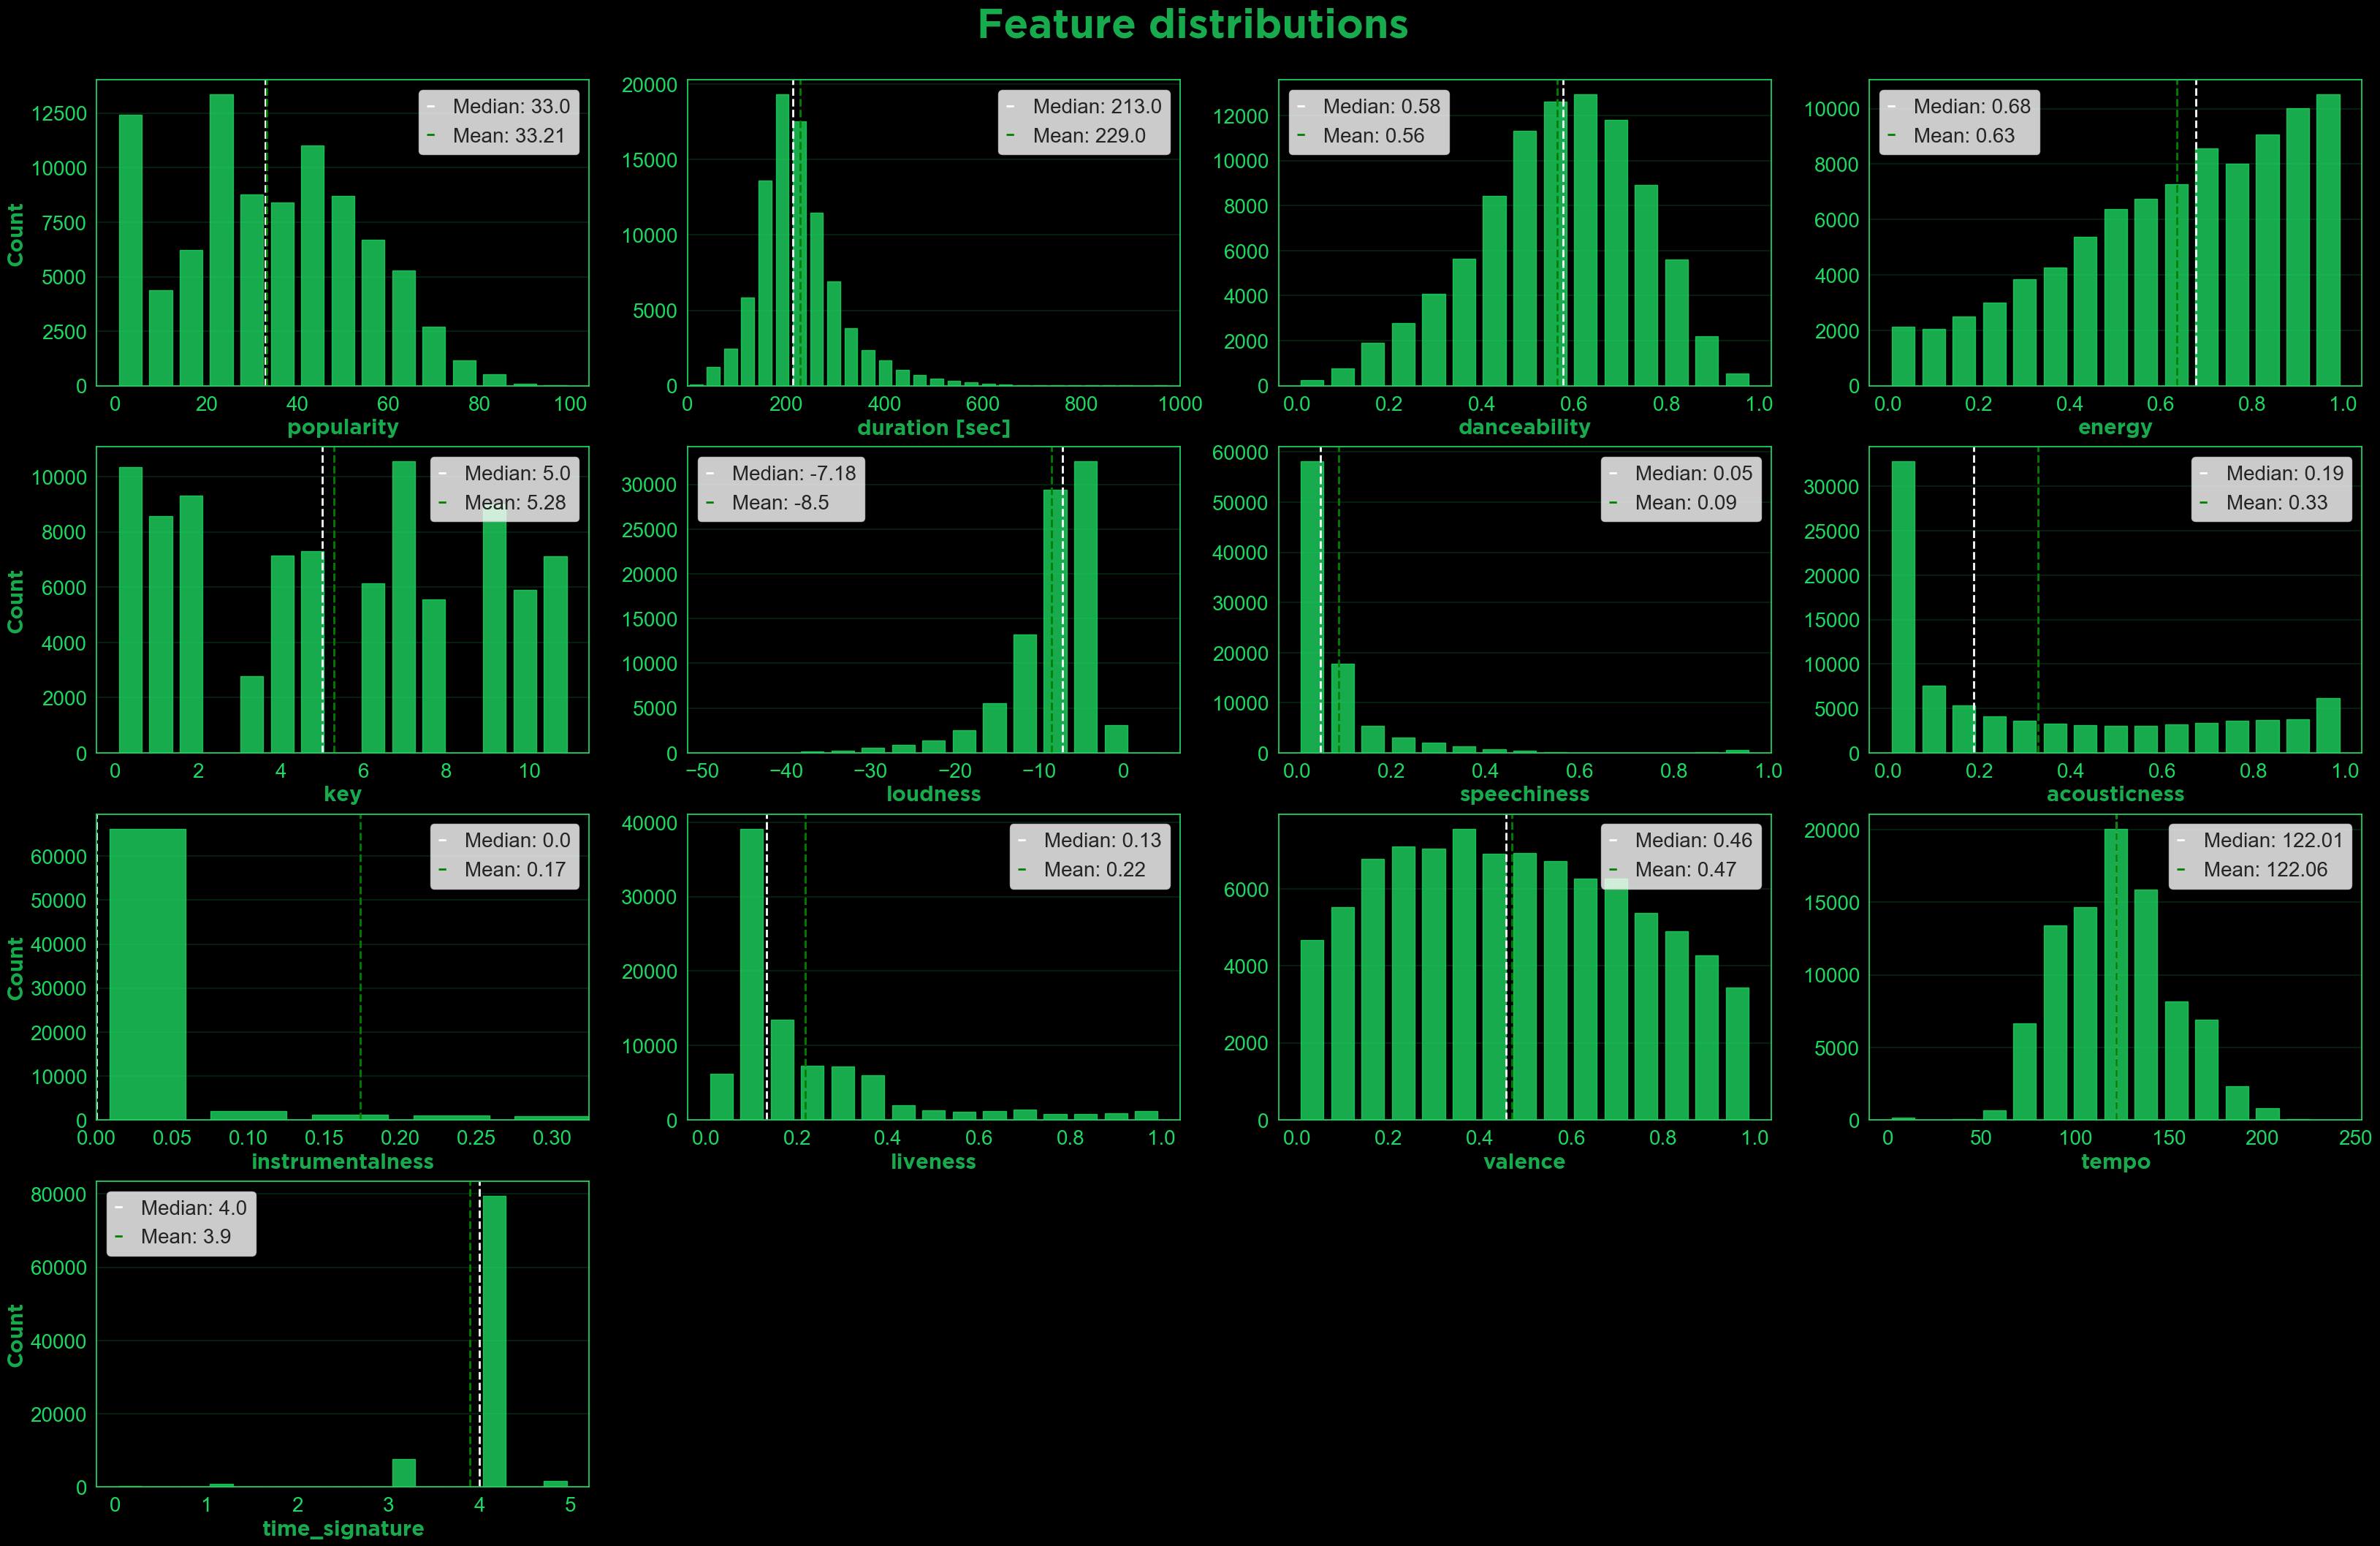

In [21]:
# COLUMN HISTOGRAMS
fpath = Path(mpl.get_data_path(), r"C:\Users\diego\OneDrive\Desktop\CoderHouse\GothamBold.ttf")
sns.set_theme (style= 'white')
columns = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

cols = 4 # max numer of columns
rows = len(columns) // cols + 1 if len(columns) % cols !=0 else len(columns) // cols
fig,ax1 = plt.subplots(nrows = rows, ncols = cols, figsize = (40,25))
fig.suptitle ('Feature distributions', fontsize = 40, fontweight = 'bold', alpha = 0.8, y = 0.92, color = '#1ED761', font=fpath)
fig.set_facecolor('#000000')

for i in range(len(columns)):
    ax = ax1.flat[i]
    ax.set_ylabel('Count', fontsize = 21, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath) if i % cols == 0 else ax.set_ylabel('')
    ax.grid(axis = 'y', lw = 0.2, color = '#1ED761')
    ax.set_facecolor('#000000')
    
    if columns[i] != 'duration_ms':
        ax.set_xlabel(columns[i], fontsize = 21, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
        ax.hist(x= df[columns[i]], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75, color = '#1ED761', alpha = 0.8, edgecolor = '#1ED761')
        ax.axvline(x = df[columns[i]].median(), c='w', ls='--', lw=2, label = 'Median: ' + str(round(df[columns[i]].median(),2)) )
        ax.axvline(x = df[columns[i]].mean(), c='green', ls='--', lw=2, label = 'Mean: ' + str(round(df[columns[i]].mean(),2)) )
        ax.legend(loc = 'best', handlelength = 0.5, markerscale = 2.5, fontsize = 20)
        if columns[i] == 'instrumentalness':
            ax.set_xlim(0,df.instrumentalness.median() + df.instrumentalness.std())
            
    else:
        ax.set_xlabel('duration [sec]', fontsize = 21, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
        ax.hist(x= df[columns[i]]/1000, bins=150, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75, color = '#1ED761', alpha = 0.8, edgecolor = '#1ED761')
        ax.set_xlim(0,1000)
        ax.axvline(x = df[columns[i]].median()/1000, c='w', ls='--', lw=2, label = 'Median: ' + str(round(df[columns[i]].median()/1000,0)) )
        ax.axvline(x = df[columns[i]].mean()/1000, c='green', ls='--', lw=2, label = 'Mean: ' + str(round(df[columns[i]].mean()/1000,0)) )
        ax.legend(loc = 'best', handlelength = 0.5, markerscale = 2.5, fontsize = 20)
      
    ax.tick_params (axis='x', colors = '#1ED761', labelsize = 20)
    ax.tick_params (axis='y', colors = '#1ED761', labelsize = 20)

    for spine in ax.spines:
        ax.spines[spine].set_color('#1ED761')

for ax in ax1.flat:
    if not ax.has_data():
        fig.delaxes(ax)

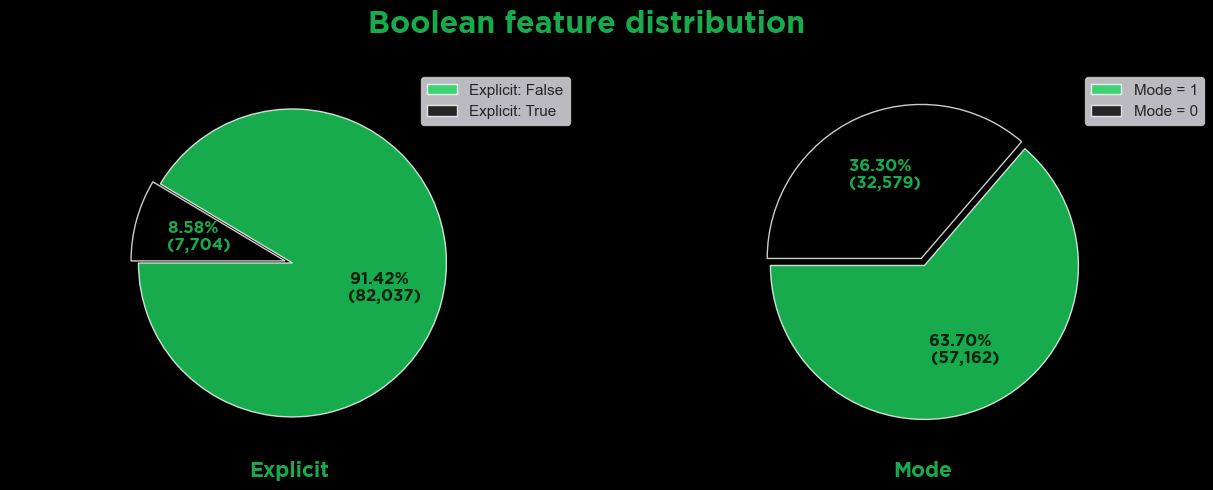

In [22]:
# PLOTTING BOOLEAN VARIABLES
sns.set_theme()

columns = ['explicit', 'mode']

cols = 2 # max numer of columns
rows = len(columns) // cols + 1 if len(columns) % cols != 0 else len(columns) // cols
fig,ax1 = plt.subplots(nrows = rows, ncols = cols, figsize = (15,5))
fig.suptitle ('Boolean feature distribution', fontsize = 22, fontweight = 'bold', alpha = 0.8, y = 1, color = '#1ED761', font=fpath)
fig.set_facecolor('#000000')

for i in range(len(columns)):
    ax = ax1.flat[i]
    patches, texts, autotexts = ax.pie(df[columns[i]].value_counts(), labels = ['Explicit: False', 'Explicit: True'] if columns[i] == 'explicit' else ['Mode = 1','Mode = 0'], autopct=lambda pct : '{:.2f}% \n ({:,.0f})'.format(pct,pct * sum(df[columns[i]].value_counts())/100), pctdistance= 0.6 ,explode = (0.025,0.025), startangle = 180, textprops= {'color': '#000000', 'weight': 'bold', 'size': '12', 'font': fpath, 'alpha': 0.8}, colors = ['#1ED761','#000000'], wedgeprops = {'alpha': 0.8})
    ax.set_xlabel(columns[i].capitalize(), fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font = fpath)
    ax.legend(loc = 'upper right', bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))
    autotexts[0].set_color('#000000')
    autotexts[1].set_color('#1ED761')
    

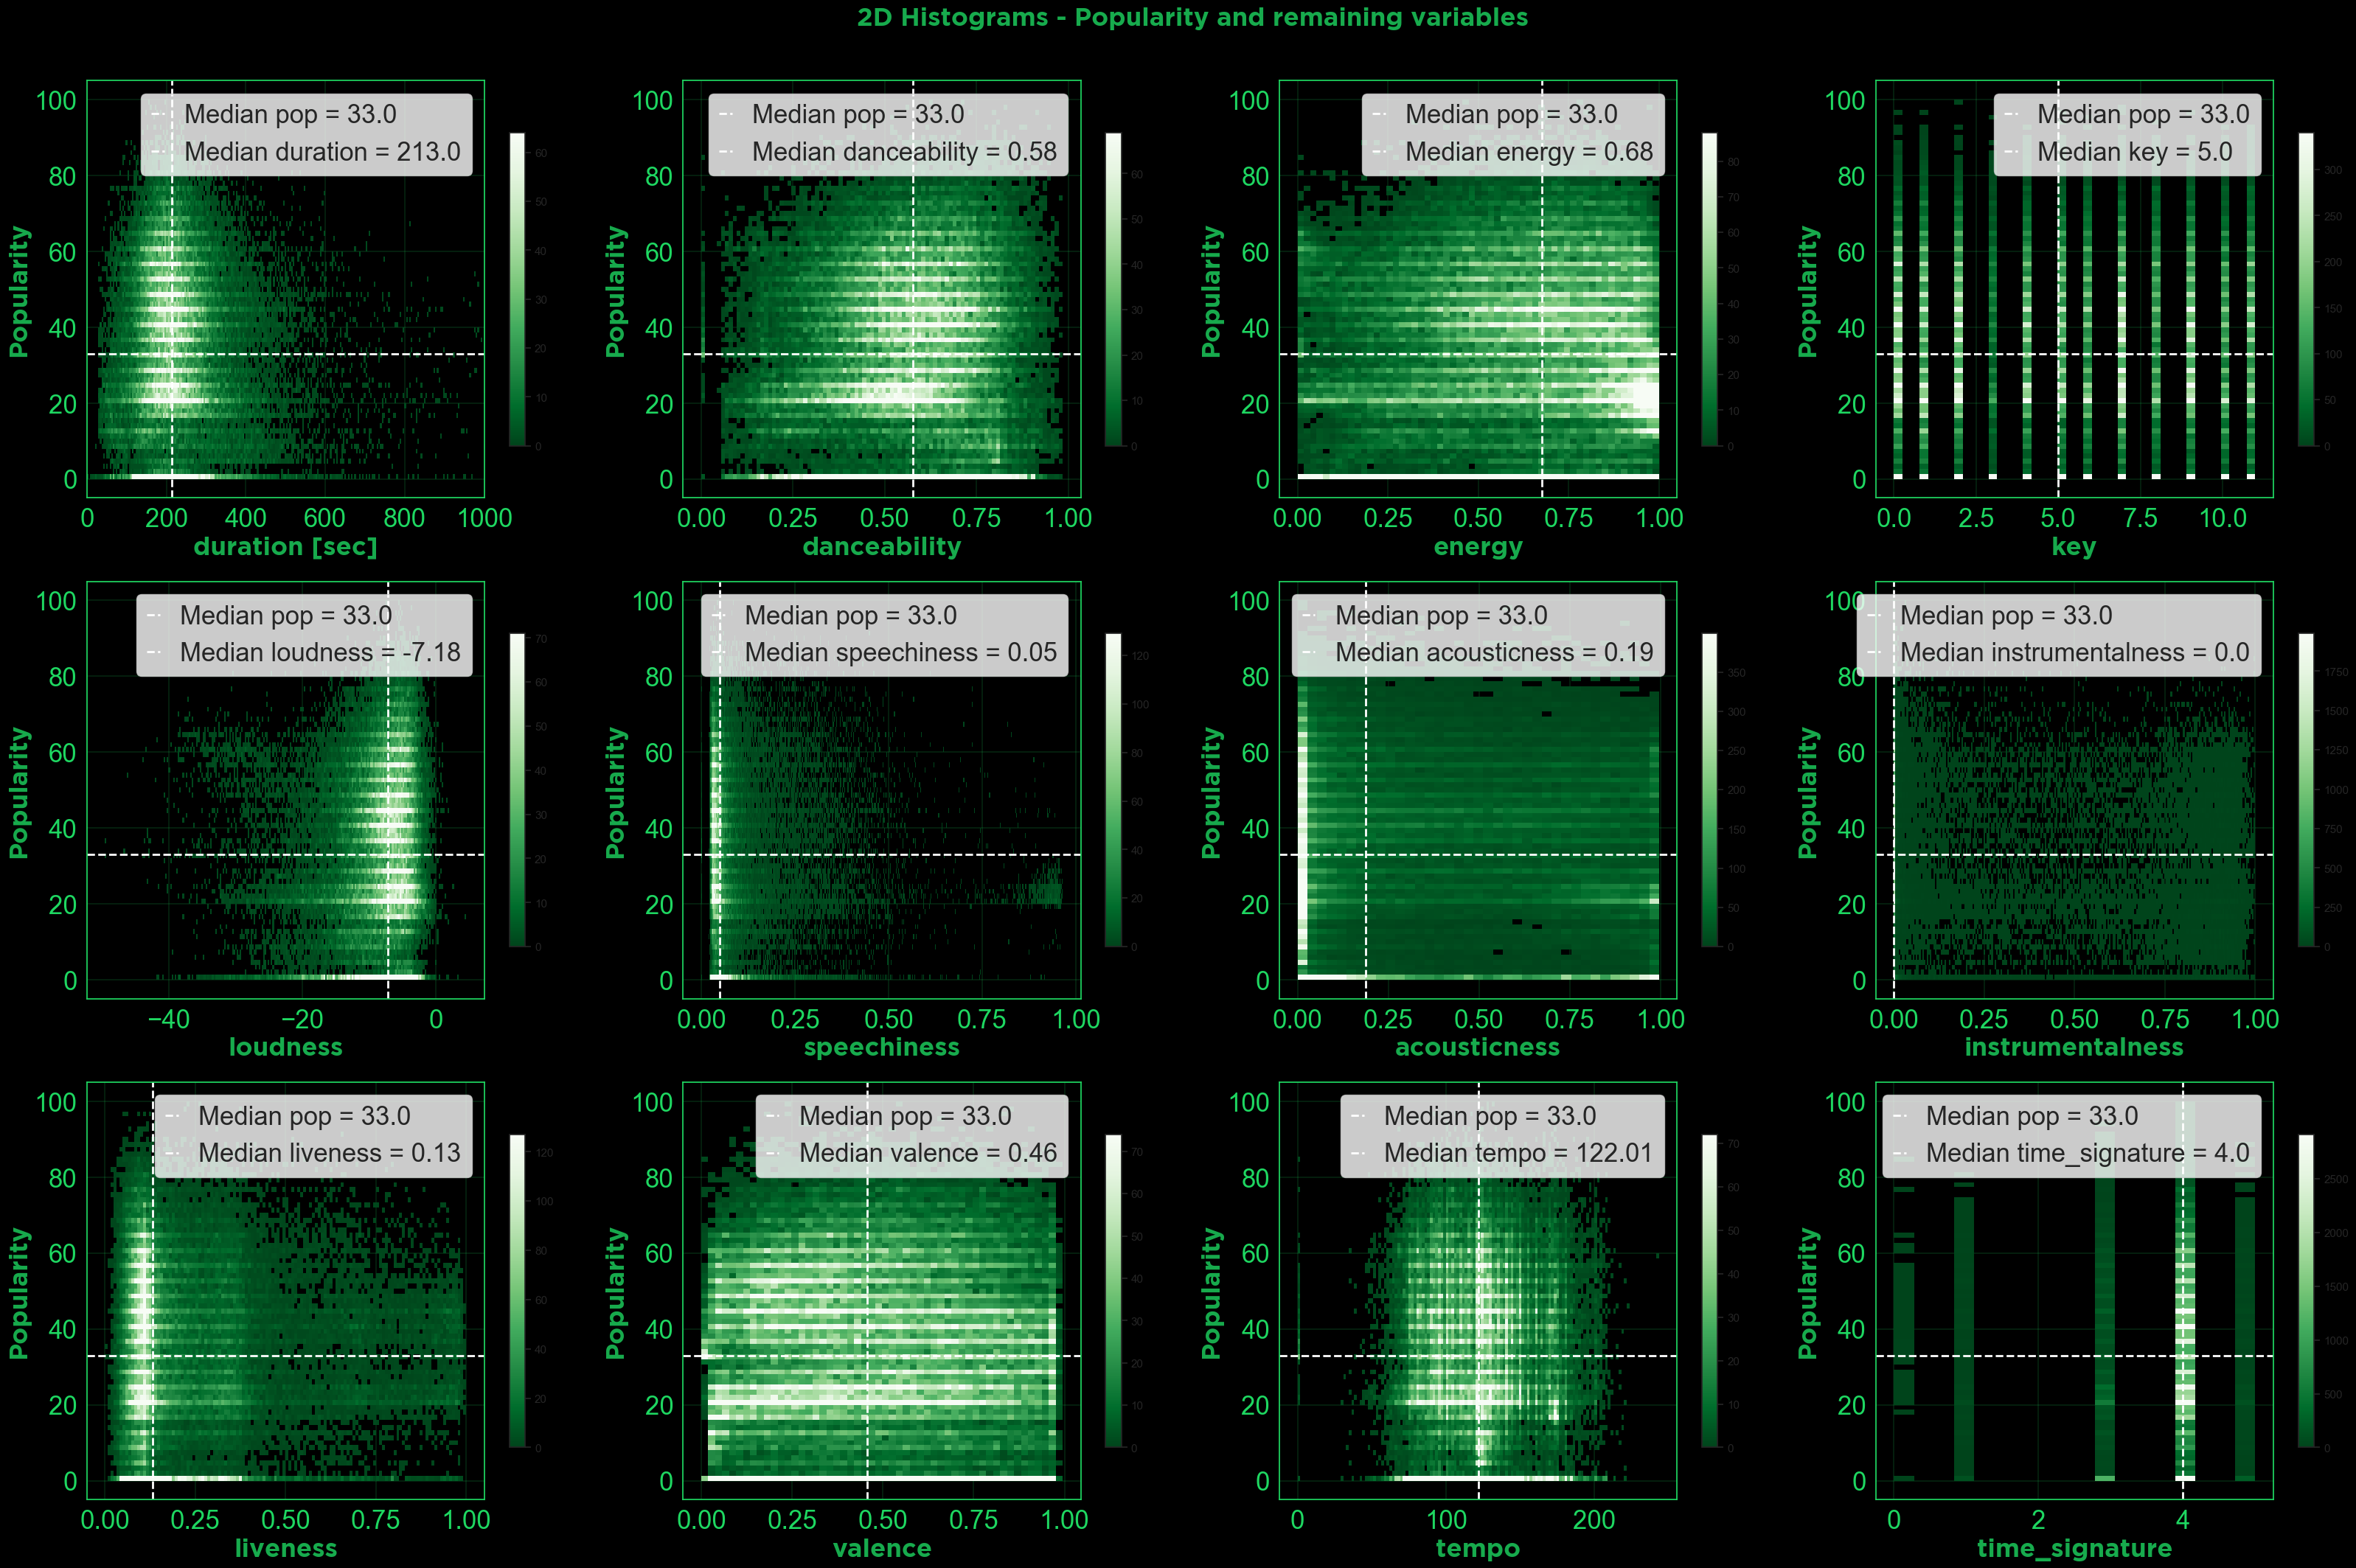

In [23]:
# DENSITY PLOTS (2D HISTOGRAMS) FOR POPULARITY AND REMAINING VARIABLES
sns.set_style('white')

columns = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

cols = 4 # max numer of columns
rows = len(columns) // cols + 1 if len(columns) % cols !=0 else len(columns) // cols
fig,ax1 = plt.subplots(nrows = rows, ncols = cols, figsize = (40,25))
fig.suptitle ('2D Histograms - Popularity and remaining variables', fontsize = 25, fontweight = 'bold', alpha = 0.8, y = 0.92, color = '#1ED761', font=fpath)
fig.set_facecolor('#000000')

for i in range(len(columns)):
    ax = ax1.flat[i]
    ax.grid(True, lw = 0.2, color = '#1ED761')
    ax.set_facecolor('#000000')
    ax.set_ylabel('Popularity', fontsize = 25, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    ax.axhline(y = df.popularity.median(), c='w', ls='--', lw=2, label = 'Median pop = ' + str(round(df['popularity'].median(),2)))
    if columns[i] != 'duration_ms':
        sns.histplot(ax = ax, data = df, x= columns[i], y = 'popularity', cbar=True, cbar_kws= dict(shrink = 0.75), discrete= (False, False), pmax = 0.8, cmap = 'Greens_r')
        ax.set_xlabel(columns[i], fontsize = 25, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
        ax.axvline(x = df[columns[i]].median(), c='w', ls='--', lw=2, label = f'Median {columns[i]} = {round(df[columns[i]].median(),2)}')
    else:
        h = sns.histplot(ax = ax, data = df, x= df[columns[i]]/1000, y = df['popularity'], cbar=True, cbar_kws= dict(shrink = 0.75), discrete= (False, False), pmax = 0.8, cmap = 'Greens_r')
        ax.set_xlabel('duration [sec]', fontsize = 25, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
        ax.set_xlim(0,1000)
        ax.axvline(x = df[columns[i]].median()/1000, c='w', ls='--', lw=2, label = f'Median duration = {round(df[columns[i]].median()/1000,0)}')

    ax.legend(loc = 'best', handlelength = 0.5, markerscale = 2.5, fontsize = 25)
    ax.tick_params (axis='x', colors = '#1ED761', labelsize = 25)
    ax.tick_params (axis='y', colors = '#1ED761', labelsize = 25)
    for spine in ax.spines:
        ax.spines[spine].set_color('#1ED761')    

for ax in ax1.flat:
    if not ax.has_data():
        fig.delaxes(ax)

plt.savefig('pop_hist.png')



Until now, it appears that no feature holds much predictive value for the target feature. This is studied further below

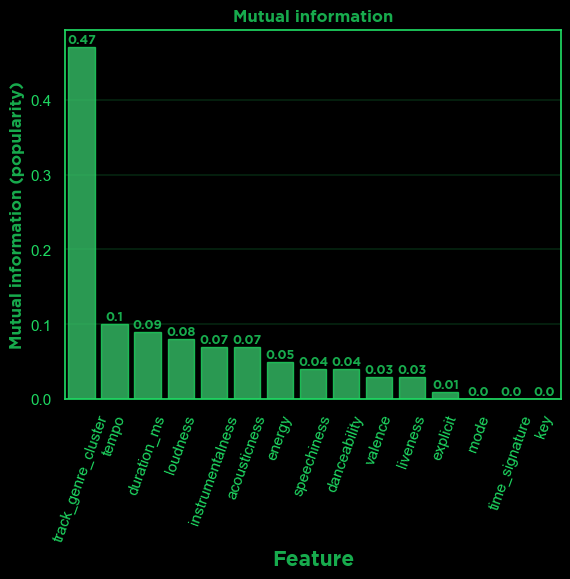

In [24]:
# Mutual information for track_genre_cluster
sns.set_theme(style='white')
cols = ['track_genre_cluster', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit', 'mode']
x = df[cols]
y = df.popularity

mi = mutual_info_regression (X = x, y = y) # look for any kind of relationship between features and target variables

mi_list = [round(i,2) for i in mi]

# Sort mi_list and cols accordingly
mi_dict = {cols[i] : mi_list[i] for i in range(len(mi_list))} # Dictionary mapping feature and mutual information

cols_sorted = sorted(mi_dict, key= mi_dict.get) 
cols_sorted.reverse() # Columns sorted by decreasing mutual information

mi_sorted = sorted(mi_dict.values())
mi_sorted.reverse() # Mutual information sorted in decreasing order

# Plotting
fig, ax = plt.subplots()
sns.barplot(x = cols_sorted, y = mi_sorted, color='#1ED761', alpha = 0.8, edgecolor = '#1ED761')
fig.set_facecolor('#000000')
ax.set_facecolor('#000000')

for i in range(len(mi_sorted)):
    params = dict (color = '#1ED761', size = 9, weight = 'bold', mouseover = True, fontstretch = 'condensed', ma = 'center', font=fpath, alpha = 0.8)
    plt.text(x=i, y=mi_sorted[i]+0.005, s=mi_sorted[i], ha='center', fontdict = params)

ax.set_xlabel ('Feature', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.set_ylabel ('Mutual information (popularity)', fontsize = 12, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.set_title ('Mutual information', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)

ax.tick_params (axis='x', colors = '#1ED761', rotation = 70)
ax.tick_params (axis='y', colors = '#1ED761')

for spine in ax.spines:
    ax.spines[spine].set_color('#1ED761')
    
ax.grid(axis= 'y', lw = 0.2, color = '#1ED761')


From the above plot, track genre cluster seems to be the feature with more predictive power for determining popularity

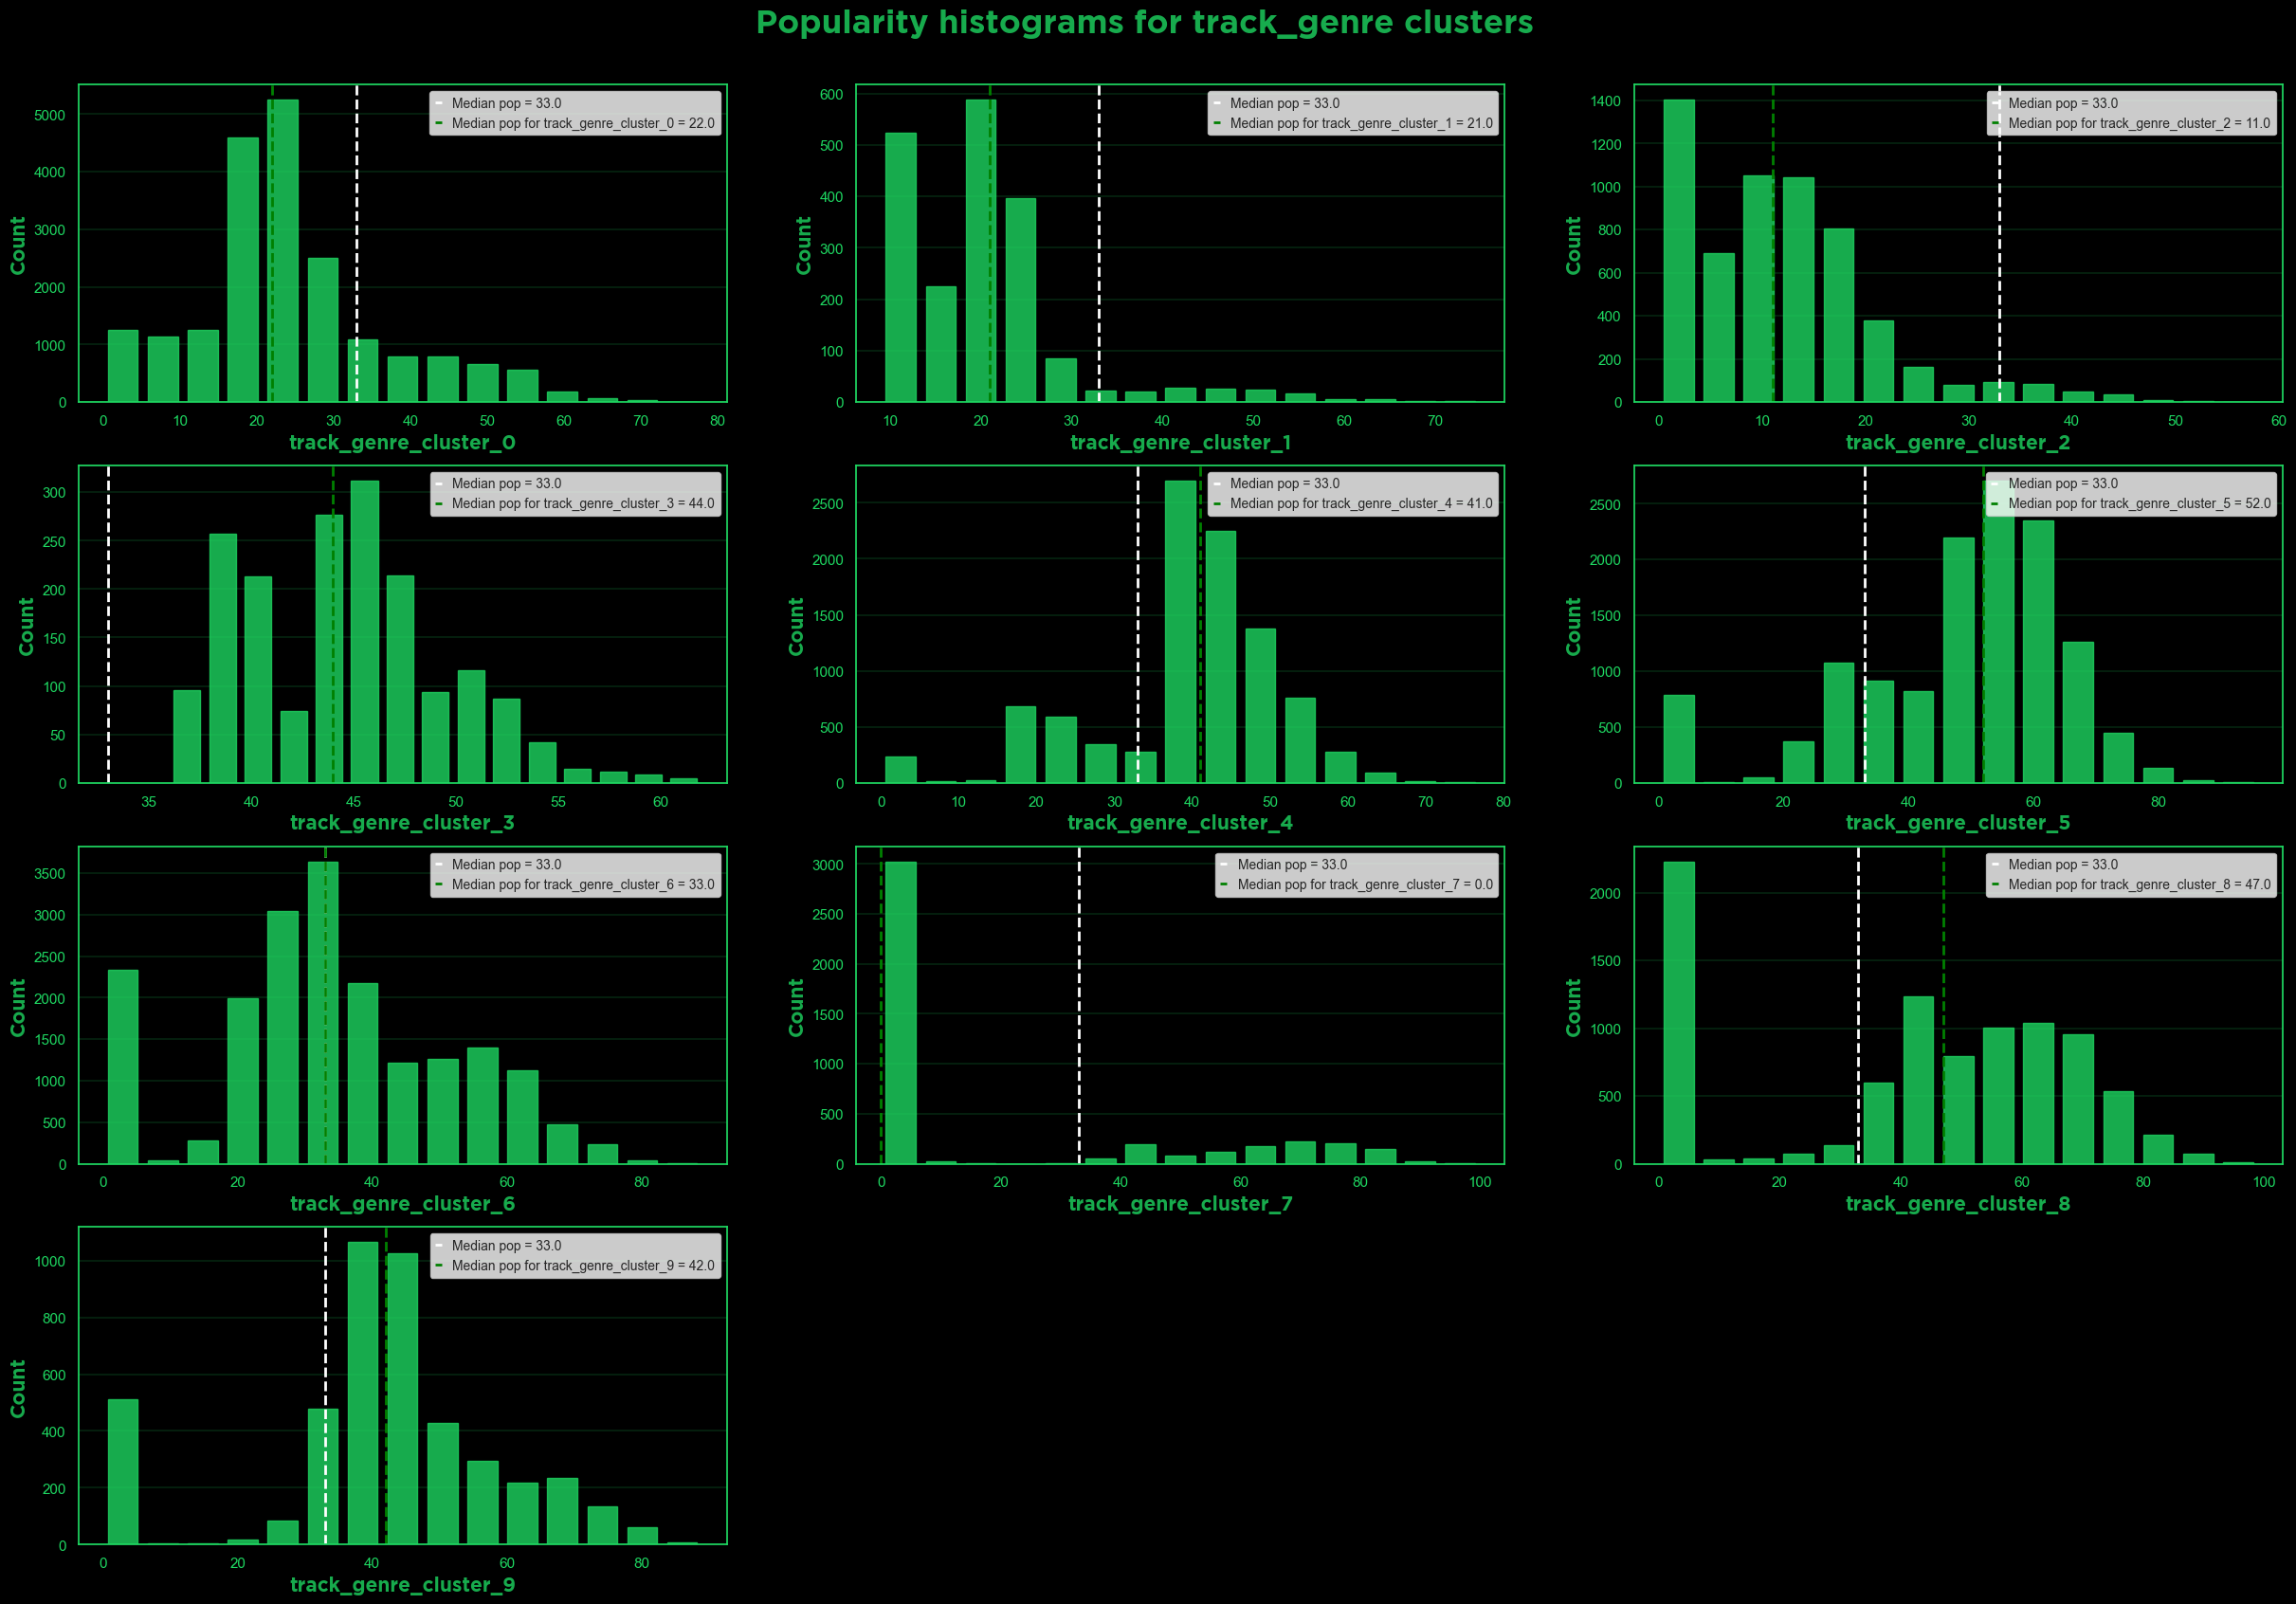

In [25]:
# POPULARITY HISTOGRAMS BY track_genre_cluster
sns.set_style('white')

columns = set (df['track_genre_cluster'])

cols = 3 # max numer of columns
rows = len(columns) // cols + 1 if len(columns) % cols !=0 else len(columns) // cols
fig,ax1 = plt.subplots(nrows = rows, ncols = cols, figsize = (30,20))
fig.suptitle ('Popularity histograms for track_genre clusters', fontsize = 25, fontweight = 'bold', alpha = 0.8, y = 0.92, color = '#1ED761', font=fpath)
fig.set_facecolor('#000000')

for i in range(len(columns)):
    ax = ax1.flat[i]
    ax.set_ylabel('Count', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    ax.grid(axis= 'y', lw = 0.2, color = '#1ED761')
    ax.set_facecolor('#000000')
    ax.set_xlabel('track_genre_cluster_' + str(i), fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    ax.hist(x= df[df['track_genre_cluster'] == i]['popularity'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75, color = '#1ED761', alpha = 0.8, edgecolor = '#1ED761')
    ax.axvline(x = df.popularity.median(), c='w', ls='--', lw=2, label = 'Median pop = ' + str(round(df['popularity'].median(),2)))
    ax.axvline(x = df[df['track_genre_cluster'] == i].popularity.median(), c='green', ls='--', lw=2, label = f'Median pop for track_genre_cluster_{i} = ' + str(round(df[df['track_genre_cluster'] == i].popularity.median(),2)))
    ax.legend (loc = 'best', handlelength = 0.5, markerscale = 2.5, fontsize = 10)

    ax.tick_params (axis='x', colors = '#1ED761')
    ax.tick_params (axis='y', colors = '#1ED761')

    for spine in ax.spines:
        ax.spines[spine].set_color('#1ED761')
    

for ax in ax1.flat:
    if not ax.has_data():
        fig.delaxes(ax)


#### **Feature Selection**

##### **PCA**
PCA will be carried out to determine if it is necessary to work with all the existing features

In [26]:
columns = df.columns.to_list()

# Remove columns with strings as well as target variable
columns.pop(columns.index('popularity'))
columns.pop(columns.index('track_id'))
columns.pop(columns.index('artists'))
columns.pop(columns.index('album_name')) 
columns.pop(columns.index('track_name'))
columns.pop(columns.index('explicit')) 
columns.pop(columns.index('track_genre'))
columns.pop(columns.index('track_genre_cluster'))

# Generate arrays with input and target variables
df_data = df[columns]
df_target = df['popularity'].to_numpy()

# Data scaling
df_data_scaled = StandardScaler().fit_transform(df_data)

In [27]:
# Auxiliary function to parametrically name columns of principal components 
def PC (list):
    for element in list:
        list[list.index(element)] = 'PC' + str(element)
    return list

ncomp = 0.95 # Define desired number of components (ncomp > 1) or desired explained variance (0 < ncomp < 1)

# PCA
pca = PCA (n_components = ncomp, svd_solver = 'full')
pca_features = pca.fit_transform (df_data_scaled)

print (f'Shape before PCA: {df_data_scaled.shape}')
print (f'Shape after PCA: {pca_features.shape}')
print (f'Percentage of variance explained: {round(100*pca.explained_variance_ratio_.cumsum()[-1],1)}%')

cols = PC(list(range(1, len(pca_features[0]) + 1)))
pca_df = pd.DataFrame (data = pca_features, columns = cols)

pca_df.head()

Shape before PCA: (89741, 23)
Shape after PCA: (89741, 19)
Percentage of variance explained: 96.2%


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-0.655656,-0.571946,-0.342833,-0.028010,0.505069,1.817536,-1.189803,-1.244194,0.381562,-0.008073,-0.023027,0.836619,1.663246,-1.065129,-0.030727,0.767073,0.776675,0.333040,0.151254
1,3.116238,-1.191026,-1.274452,0.577993,0.791893,0.802631,-2.091793,-0.742094,0.775877,-0.008275,0.110128,0.777355,0.645338,-0.123359,-0.771458,0.020204,0.413042,-0.698276,0.578892
2,1.370723,0.111787,-0.768487,0.911249,0.946165,0.956235,-2.170812,-0.370241,1.194790,0.121858,-0.356625,0.847937,1.331444,-0.207126,-0.555835,-0.246662,-0.247565,-0.946504,0.342623
3,3.595456,-0.142331,-0.517202,1.241007,1.185160,0.104327,-3.124107,0.024165,0.466893,-0.453449,-0.171131,-0.190064,-1.604091,-0.072138,1.392612,1.236292,0.999170,0.026567,0.611702
4,0.915313,-0.073323,-1.069040,0.438272,0.887802,0.936887,-2.109901,-0.618010,0.844319,0.002373,-0.161288,0.850465,0.104944,0.158145,-0.043791,-0.029941,-0.018969,-0.459976,0.580500


C:\Users\diego\AppData\Local\Temp\ipykernel_3956\789047609.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


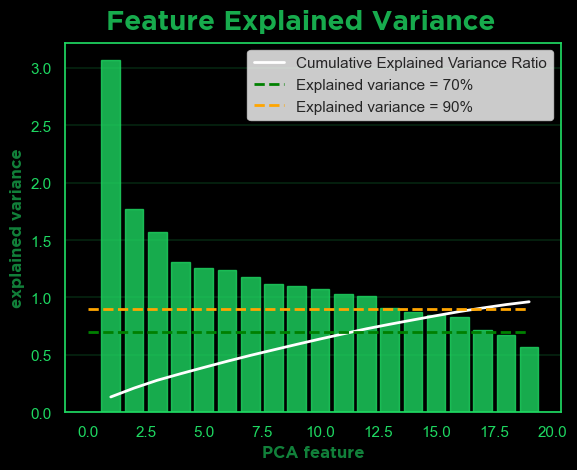

In [28]:
mpl.style.use('seaborn-deep')

fig,ax = plt.subplots()
fig.set_facecolor('#000000')
fig.suptitle ('Feature Explained Variance ', fontsize = 20, fontweight = 'bold', alpha = 0.8, y = 0.95, color = '#1ED761', font=fpath)
ax.tick_params (axis='x', colors = '#1ED761')
ax.tick_params (axis='y', colors = '#1ED761')
ax.grid(axis= 'y', lw = 0.2, color = '#1ED761')
for spine in ax.spines:
        ax.spines[spine].set_color('#1ED761')

ax.set_ylabel('Explaned Variance', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.grid(axis= 'y', lw = 0.2, color = '#1ED761')
ax.set_facecolor('#000000')
ax.set_xlabel('PCA Feature', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
ax.bar(range(1,len(pca.explained_variance_) + 1), height= pca.explained_variance_, color = '#1ED761', alpha = 0.8, edgecolor = '#1ED761')

plt.xlabel ('PCA feature', fontsize = 12, fontweight = 'bold', alpha = 0.6 )
plt.ylabel ('explained variance', fontsize = 12, fontweight = 'bold', alpha = 0.6 )


plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), c = 'white', label = 'Cumulative Explained Variance Ratio', lw = 2)
plt.plot(list(range(0,20)), 0.7*np.ones(20), label = 'Explained variance = 70%', color = 'green', ls = '--', lw = 2)
plt.plot(list(range(0,20)), 0.9*np.ones(20), label = 'Explained variance = 90%', color = 'orange', ls = '--', lw = 2)

plt.legend (loc = 'upper right')

Approximately 12 and 17 features should be used for getting an explained variance of 70% and 90% respectively. Given that the total number of features isn't too high, and that the number of features that should be kept for getting an acceptable amount of explained variance is close to the total number of features, no reduction of dimensionality is used for the analysis

#### **MODELS**

##### **Data Preparation and splitting**

In [29]:
# Generate arrays with input and target variables
columns = ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
df_data = df[columns]

# Data scaling
df_data_scaled = StandardScaler().fit_transform(df_data)
df_data_scaled_df = pd.DataFrame(data=df_data_scaled, columns=columns)

clusters = []

for i in range(0,kmeans._n_features_out):
    clusters.append('track_genre_cluster_' + str(i))

df_genres = df[clusters]

df_data_scaled_df = pd.concat([df_data_scaled_df, df_genres], axis=1) # Add dummy variables to scaled dataset

# Dataframe removing track_id, artists, album_name, track_name, explicit and track_genre (keeping track_genre_clusters)
x = df_data_scaled_df
y = df.popularity

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state=0) # split dataset into test and train dataset

##### **Model Creation**

In [30]:
# Linear Model (SGD).
reg = SGDRegressor(random_state=0)
reg.fit(x_train, y_train)
predic_sgd = reg.predict(x_val)
predic_train_sgd = reg.predict(x_train)

In [31]:
# Linear Model (SGD). Generalization error is estimated via 10-fold cross validation
reg = SGDRegressor(random_state=0)
scores = cross_validate(estimator = reg, X = x, y = y, cv = 10, scoring = 'neg_root_mean_squared_error') # 10-fold cross validation

print (f"RMSE for 10-fold SGD cross validation = {round(-scores['test_score'].mean(),2)}")

RMSE for 10-fold SGD cross validation = 17.74


In [32]:
# KNN model, choosing K through 5-fold cross validation
# As the relationship between predictors and target variable seems not to be linear, smaller values of K are expected to work better than bigger values. 
# Hence, k is set between 5 and 15, choosing the value with minimum cross validation error (mean error across splits)

k_values = list(range(5,16)) # Values of K to try
xval_scores = {}

for k in tqdm(k_values):
    knn = KNeighborsRegressor(n_neighbors = k)
    scores = cross_validate(estimator = knn, X = x, y = y, cv = 5) # 5-fold cross validation
    xval_scores[k] = (scores['test_score']).mean() # Storing the mean error for each value of k

for key, val in xval_scores.items():
    if val == min(xval_scores.values()):
        k_opt = key # optimum K is the one with minimum cross-validation error

print (k_opt)
xval_scores

100%|██████████| 11/11 [04:22<00:00, 23.82s/it]

5


{5: 0.0038829288483062108,
 6: 0.03338397347989053,
 7: 0.05356020257438987,
 8: 0.07058556739282232,
 9: 0.08229349489796309,
 10: 0.08858370367867582,
 11: 0.09394060031736792,
 12: 0.10051243681093447,
 13: 0.1053680820403784,
 14: 0.11026936516889052,
 15: 0.11536950553666796}

In [33]:
# KNN 
knn = KNeighborsRegressor(n_neighbors = k_opt)
knn.fit(x_train, y_train)
predic_knn = knn.predict(x_val)
predic_train_knn = knn.predict(x_train)

In [34]:
# KNN. Generalization error is estimated via 10-fold cross validation
knn = KNeighborsRegressor(n_neighbors = k_opt)
scores = cross_validate(estimator = knn, X = x, y = y, cv = 10, scoring = 'neg_root_mean_squared_error') # 10-fold cross validation

print (f"RMSE for 10-fold 5-NN cross validation = {round(-scores['test_score'].mean(),2)}")

RMSE for 10-fold 5-NN cross validation = 20.16


In [35]:
# Random Forest (Randomized Search)
param_distributions = {'n_estimators': [50,75,100,150,200],
                    'max_depth': [None, 2,3,4,5],
                    'max_features':[None,'sqrt','log2']
                    }
rf = RandomForestRegressor(random_state = 0)
rs = RandomizedSearchCV(rf, param_distributions, random_state = 0)

search = rs.fit(x_train, y_train)

search.best_params_

{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None}

In [36]:
# Random Forest
rf = RandomForestRegressor(random_state = 0, max_features  = 'sqrt', n_estimators = 100, max_depth = None) #parameters from Randomized Search optimization
rf.fit(x_train, y_train)
predic_rf = rf.predict(x_val)
predic_train_rf = rf.predict(x_train)


In [37]:
# HGBOOST
params = {
    "learning_rate": 0.1,
    "max_iter": 100,
    "max_leaf_nodes": None,
    "min_samples_leaf": 5,
}

reg_hg = HistGradientBoostingRegressor(**params) # HGBoost

reg_hg.fit(x_train, y_train)

predic_hg = reg_hg.predict(x_val.values)
predic_train_hg = reg_hg.predict(x_train.values)


c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(


### **Evaluation**

In [38]:
# SGD
print ('----------------------------------------------------\nSGD')
print(f'- RMSE for training dataset = {round(mean_squared_error (y_true = y_train, y_pred = predic_train_sgd, squared = False),2)}')
print(f'- RMSE for validation dataset = {round(mean_squared_error (y_true = y_val, y_pred = predic_sgd, squared = False),2)}')
print(f'- Max error for training dataset = {round(max_error (y_true = y_train, y_pred = predic_train_sgd),2)}')
print(f'- Max error for validation dataset = {round(max_error (y_true = y_val, y_pred = predic_sgd),2)}')
print(f'- Explained variance score for training dataset = {round(100*explained_variance_score (y_true = y_train, y_pred = predic_train_sgd),2)}%')
print(f'- Explained variance score for validation dataset = {round(100*explained_variance_score (y_true = y_val, y_pred = predic_sgd),2)}%')


# KNN
print ('----------------------------------------------------\nKNN')
print(f'- RMSE for training dataset = {round(mean_squared_error (y_true = y_train, y_pred = predic_train_knn, squared = False),2)}')
print(f'- RMSE for validation dataset = {round(mean_squared_error (y_true = y_val, y_pred = predic_knn, squared = False),2)}')
print(f'- Max error for training dataset = {round(max_error (y_true = y_train, y_pred = predic_train_knn),2)}')
print(f'- Max error for validation dataset = {round(max_error (y_true = y_val, y_pred = predic_knn),2)}')
print(f'- Explained variance score for training dataset = {round(100*explained_variance_score (y_true = y_train, y_pred = predic_train_knn),2)}%')
print(f'- Explained variance score for validation dataset = {round(100*explained_variance_score (y_true = y_val, y_pred = predic_knn),2)}%')

# HGBoost
print ('----------------------------------------------------\nHGBoost')
print(f'- RMSE for training dataset = {round(mean_squared_error (y_true = y_train, y_pred = predic_train_hg, squared = False),2)}')
print(f'- RMSE for validation dataset = {round(mean_squared_error (y_true = y_val, y_pred = predic_hg, squared = False),2)}')
print(f'- Max error for training dataset = {round(max_error (y_true = y_train, y_pred = predic_train_hg),2)}')
print(f'- Max error for validation dataset = {round(max_error (y_true = y_val, y_pred = predic_hg),2)}')
print(f'- Explained variance score for training dataset = {round(100*explained_variance_score (y_true = y_train, y_pred = predic_train_hg),2)}%')
print(f'- Explained variance score for validation dataset = {round(100*explained_variance_score (y_true = y_val, y_pred = predic_hg),2)}%')


# Random Forest
print ('----------------------------------------------------\nRandom Forest')
print(f'- RMSE for training dataset = {round(mean_squared_error (y_true = y_train, y_pred = predic_train_rf, squared = False),2)}')
print(f'- RMSE for validation dataset = {round(mean_squared_error (y_true = y_val, y_pred = predic_rf, squared = False),2)}')
print(f'- Max error for training dataset = {round(max_error (y_true = y_train, y_pred = predic_train_rf),2)}')
print(f'- Max error for validation dataset = {round(max_error (y_true = y_val, y_pred = predic_rf),2)}')
print(f'- Explained variance score for training dataset = {round(100*explained_variance_score (y_true = y_train, y_pred = predic_train_rf),2)}%')
print(f'- Explained variance score for validation dataset = {round(100*explained_variance_score (y_true = y_val, y_pred = predic_rf),2)}%')

----------------------------------------------------
SGD
- RMSE for training dataset = 17.6
- RMSE for validation dataset = 17.44
- Max error for training dataset = 79.5
- Max error for validation dataset = 75.11
- Explained variance score for training dataset = 26.95%
- Explained variance score for validation dataset = 27.86%
----------------------------------------------------
KNN
- RMSE for training dataset = 14.49
- RMSE for validation dataset = 17.82
- Max error for training dataset = 88.8
- Max error for validation dataset = 86.4
- Explained variance score for training dataset = 50.52%
- Explained variance score for validation dataset = 24.7%
----------------------------------------------------
HGBoost
- RMSE for training dataset = 7.06
- RMSE for validation dataset = 16.41
- Max error for training dataset = 81.48
- Max error for validation dataset = 86.85
- Explained variance score for training dataset = 88.26%
- Explained variance score for validation dataset = 36.2%
----------

#### **Error Plotting**

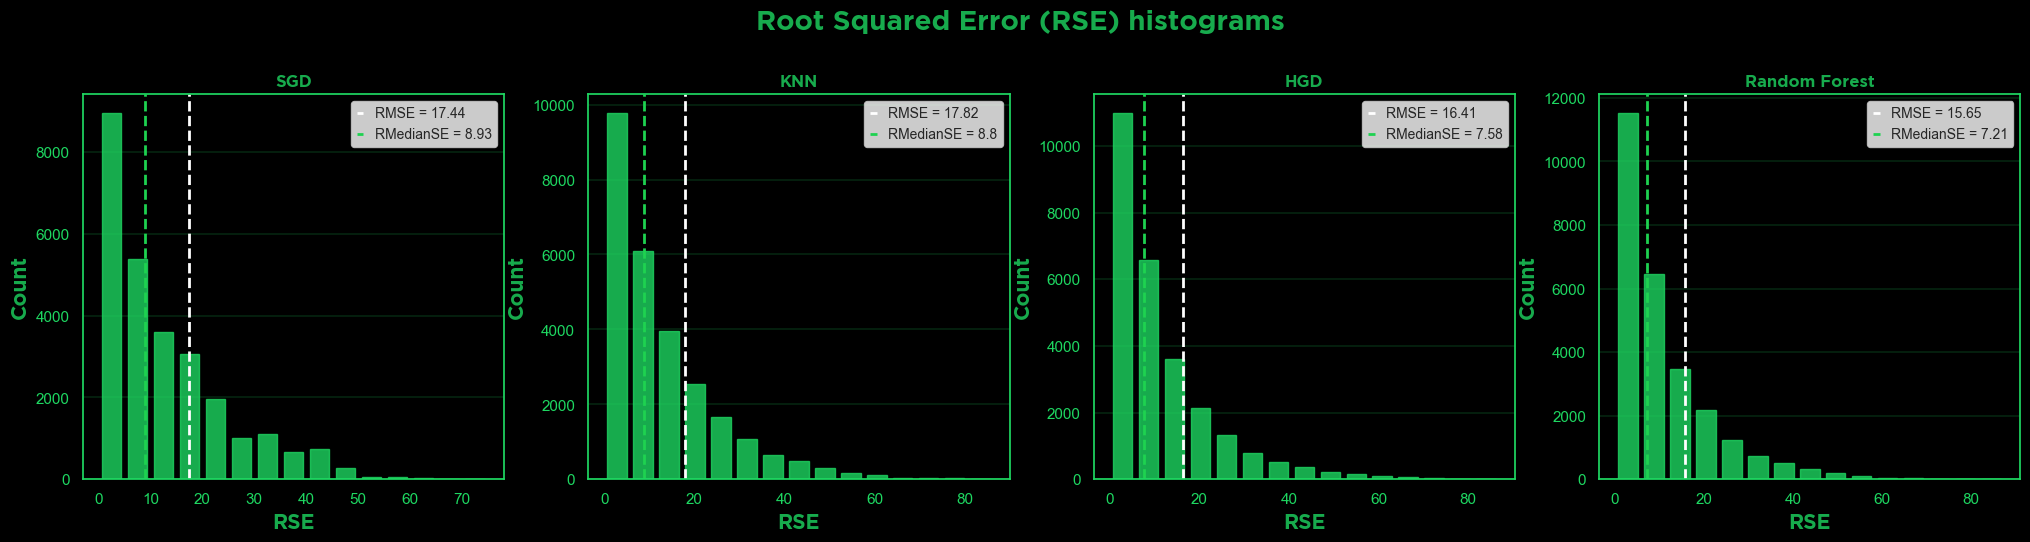

In [39]:
predictions = [predic_sgd, predic_knn, predic_hg, predic_rf]
predictions_str = ['SGD', 'KNN', 'HGD', 'Random Forest']

errors = []
for pred in predictions:
    errors.append({'rse' : np.sqrt(np.square(pred - y_val)),
                    'rmse' : np.sqrt(np.mean(np.square(pred - y_val))),
                    'rmedse': np.sqrt(np.median(np.square(pred - y_val)))  
                         })


fig,ax1 = plt.subplots(nrows = 1, ncols = 4, figsize = (25,5))
fig.set_facecolor('000000')
fig.suptitle ('Root Squared Error (RSE) histograms', fontsize = 20, fontweight = 'bold', alpha = 0.8, y = 1.05, color = '#1ED761', font=fpath)

for i in range(4):
    ax = ax1.flat[i]
    ax.set_ylabel('Count', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    ax.grid(axis= 'y', lw = 0.2, color = '#1ED761')
    ax.set_facecolor('#000000')
    ax.set_xlabel('RSE', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    ax.set_title (label = predictions_str[i], fontsize = 20, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    
    ax.hist(x= errors[i]['rse'], bins=15, density=False, orientation='vertical', histtype = 'barstacked', rwidth = 0.75, color = '#1ED761', alpha = 0.8, edgecolor = '#1ED761')
    ax.axvline(x = errors[i]['rmse'], c='w', ls='--', lw=2, label = 'RMSE = ' + str(round(errors[i]['rmse'],2)))
    ax.axvline(x = errors[i]['rmedse'], c='#1ED250', ls='--', lw=2, label = 'RMedianSE = ' + str(round(errors[i]['rmedse'],2)))
    ax.legend (loc = 'best', handlelength = 0.5, markerscale = 2.5, fontsize = 10)

    for spine in ax.spines:
        ax.spines[spine].set_color('#1ED761')

    ax.tick_params (axis='x', colors = '#1ED761')
    ax.tick_params (axis='y', colors = '#1ED761')


C:\Users\diego\AppData\Local\Temp\ipykernel_3956\27456272.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-deep')


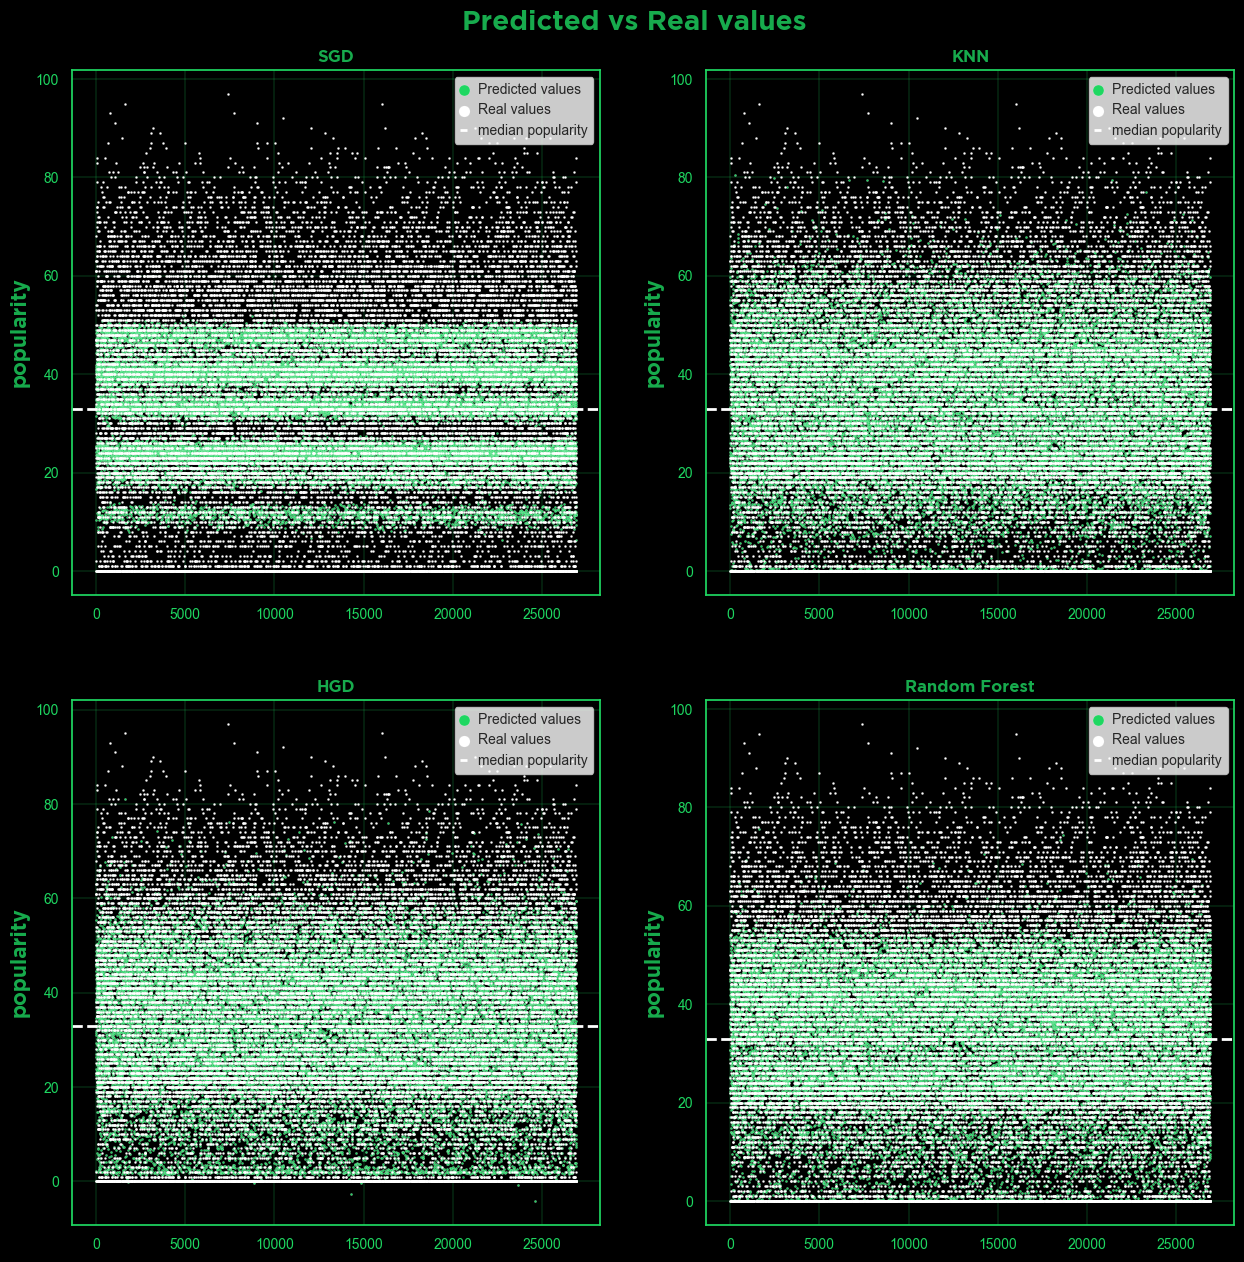

In [40]:
# Visualization of predicted vs real values
mpl.style.use('seaborn-deep')
fig,ax1 = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
fig.suptitle ('Predicted vs Real values', fontsize = 20, fontweight = 'bold', alpha = 0.8, y = 0.92, color = '#1ED761', font=fpath)
fig.set_facecolor('#000000')

for i in range(4):
    ax = ax1.flat[i]
    ax.set_ylabel('popularity', fontsize = 15, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    ax.set_title (predictions_str[i], fontsize = 20, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)
    ax.grid(lw = 0.2, color = '#1ED761')
    ax.set_title (label = predictions_str[i], fontsize = 20, fontweight = 'bold', alpha = 0.8, color = '#1ED761', font=fpath)

    x_plot = range(1,len(predictions[i])+1)
    sns.scatterplot(ax = ax, x = x_plot, y = predictions[i], s = 2.5, c = '#1ED761', label = 'Predicted values')
    sns.scatterplot(ax = ax, x = x_plot, y = y_val, s = 2.5, c = 'w', label = 'Real values')
    ax.axhline(y = df.popularity.median(), c='w', ls='--', lw=2, label = 'median popularity')
    ax.legend(loc = 'upper right', handlelength = 0.5, markerscale = 5, fontsize = 10)


    ax.tick_params (axis='x', colors = '#1ED761', labelsize = 10)
    ax.tick_params (axis='y', colors = '#1ED761', labelsize = 10)
    ax.set_facecolor('#000000')
    for spine in ax.spines:
        ax.spines[spine].set_color('#1ED761')

#### **Conclusions**

Four models were trained: SGD linear model, K-Nearest Neighbours, Histogram-based Gradient Boosting Regression Tree (HGD) and Random Forest.
First of all, it is worth noting that, for the models in which cross validation was used to estimate the generalization error (SGD and KNN), the cross validation error was fairly close to the test error.

Out of the four trained models, the one which performed worst is the SGD linear model. This can be deduced from the metrics, as it is the one with higher errors, and can also be confirmed by the errors histograms, as this is the model with higher counts for high errors. Furthermore, errors for train and test sets are similar, suggesting that this model could be underfitting the data. This makes sense, as the relationship between the target variable and the predictors seems to be non linear, making it hard for a linear model to fit the data well.

The next model to be trained was KNN, using cross validation to choose the value of K. This model performed better than the linear one, but still shows signs of underfitting. Even though the error for the train set is lower than the error in the train set, the difference is less than it should be. Furthermore, the explained variance of the training dataset is only 50%.

The last two models to be trained were HGBoost and Random Forest. These two models were the ones which performed best, as can be seen from the metrics. However, Random Forest performed slightly better than HGBoost, as the RMSE is slightly lower and the explained variance score for the test dataset is slightly higher. The results for train and test sets for these two models are fairly different, suggesting the models are not underfitting the data as much as de SGD and KNN. This can also be seen in the errors histograms, as both models show higher counts for smaller errors.

Lastly, it can be seen that, even though Random Forest was the best-performing model, it still does not do a very good job at predicting higher popularity ratings. As can be seen in the last plots, popularity ratings above 60 are never predicted, which shows the model has still room for improvement. Future actions include taking a closer look at better predicting these popularity ratings. 
